# Proof of Concept: Pulse-Relax Optimization for Salt Removal

**Objective:** Automatically find the best "Pulse Frequency" and "Pressure Ratio" to break a salt clog.
**Fixes Applied:**
1.  **Guaranteed Clogging:** High salt concentration ($C=0.55$) during the damage phase.
2.  **Gradient Flow:** Smoother pulse functions to help the optimizer learn.
3.  **Visualization:** Added 2D maps for Saturation and Solid Fraction.

---

In [7]:
# 1. SETUP & IMPORTS
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad
import optax
import matplotlib.pyplot as plt
import numpy as np

# Enable 64-bit precision for stable fluid dynamics
jax.config.update("jax_enable_x64", True)

# --- PHYSICAL CONSTANTS ---
NX, NY = 120, 40       # Domain Size
MAX_STEPS = 1500       # 0-600 (Clog), 600-1500 (Clean)
TAU = 0.9              # Viscosity
C_EQ = 0.35            # Solubility Limit
PRECIP_RATE = 0.08     # Fast precipitation
DISSOLVE_RATE = 0.15   # Fast dissolution

# D2Q9 Lattice Constants
CX = jnp.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
CY = jnp.array([0, 0, 1, 0, -1, 1, 1, -1, -1])
W = jnp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

print("System initialized. Physics engine ready.")

System initialized. Physics engine ready.


## 2. The Physics Engine
This cell contains the Differentiable LBM Solver. It handles the fluid flow, salt transport, and the **Brinkman Penalization** (where solid salt slows down fluid).

In [8]:
@jax.jit
def equilibrium(rho, u):
    """ Standard BGK Equilibrium """
    u_sq = u[..., 0]**2 + u[..., 1]**2
    f_eq_list = []
    for i in range(9):
        cu = u[..., 0]*CX[i] + u[..., 1]*CY[i]
        term = 1 + 3*cu + 4.5*cu**2 - 1.5*u_sq
        f_eq_list.append(rho * W[i] * term)
    return jnp.stack(f_eq_list, axis=-1)

@jax.jit
def pulse_policy(t, params):
    """
    Generates the Pulse-Relax Waveform.
    params[0]: Frequency
    params[1]: Pressure Amplitude (The 'Relax' depth)
    """
    freq = params[0]
    amp = params[1]
    
    P_HIGH = 1.05
    
    # Differentiable Pulse: Smoothed Square Wave using Sin
    # This is better for gradients than a hard 'if' square wave
    wave = jnp.sin(2.0 * jnp.pi * freq * t)
    
    # If wave > 0 -> High Pressure. If wave < 0 -> Relax (Low Pressure)
    # We use a soft transition to keep it differentiable
    pressure = P_HIGH - amp * jax.nn.sigmoid(-10.0 * wave)
    
    return pressure

@jax.jit
def step_physics(state, inputs):
    f, salt, phi = state
    t, control_params = inputs
    
    # --- 1. MACROSCOPIC MOMENTS ---
    rho = jnp.sum(f, axis=-1)
    # Add a small epsilon to avoid division by zero
    rho = jnp.maximum(rho, 1e-6)
    u = jnp.stack([jnp.sum(f * CX, axis=-1) / rho, jnp.sum(f * CY, axis=-1) / rho], axis=-1)
    
    # --- 2. SALT CHEMISTRY (The Gradient Fix) ---
    c_salt = jnp.sum(salt, axis=-1)
    salt_eq = equilibrium(c_salt, u)
    salt_relaxed = salt - (salt - salt_eq) / 1.0
    
    # Driving Force: Positive = Precipitate, Negative = Dissolve
    driving_force = c_salt - C_EQ
    
    # --- CRITICAL FIX 1: Soft Switch (Sigmoid) instead of Hard Switch (Where) ---
    # This allows the optimizer to "feel" the transition point
    # steepness=50.0 makes it act like a switch but keeps it differentiable
    switch = jax.nn.sigmoid(50.0 * driving_force) 
    rate = switch * PRECIP_RATE + (1.0 - switch) * DISSOLVE_RATE
    
    d_phi = rate * driving_force
    
    # --- CRITICAL FIX 2: Soft Clamping for Solid Mass ---
    # Instead of "if phi < 0: 0", we use a softplus or similar smooth bound
    # Here we just allow it to be negative transiently but clamp the result
    phi_new = jnp.clip(phi + d_phi, 0.0, 1.0)
    
    # Update Liquid Salt (Mass Conservation)
    salt_new = salt_relaxed * (1.0 - d_phi[..., None])
    
    # --- 3. HYDRODYNAMICS ---
    tau_eff = TAU + 200.0 * phi_new
    f_eq = equilibrium(rho, u)
    f_out = f - (f - f_eq) / tau_eff[..., None]
    
    # --- 4. BOUNDARY CONDITIONS (The Clogging Fix) ---
    # We extend the clogging phase to 800 steps to GUARANTEE accumulation
    CLOG_TIME = 800.0
    
    # Soft transition for time (Sigmoid over time)
    # 1.0 when t < CLOG, 0.0 when t > CLOG
    is_clogging_phase = jax.nn.sigmoid(10.0 * (CLOG_TIME - t))
    
    # Pressure: Clog(1.02) -> Clean(Pulse)
    p_clean = pulse_policy(t, control_params)
    p_in = is_clogging_phase * 1.02 + (1.0 - is_clogging_phase) * p_clean
    
    f_out = f_out.at[0, :, :].set(equilibrium(p_in * 3.0, jnp.zeros((NY, 2))))
    f_out = f_out.at[-1, :, :].set(f_out[-2, :, :]) 
    
    # Salt: Dirty(0.8) -> Fresh(0.0)
    # CRITICAL FIX 3: Increased C_IN from 0.55 to 0.8 to force massive clogging
    c_in = is_clogging_phase * 0.8 + (1.0 - is_clogging_phase) * 0.0
    
    salt_new = salt_new.at[0, :, :].set(equilibrium(c_in, u[0, :, :]))
    salt_new = salt_new.at[-1, :, :].set(salt_new[-2, :, :])
    
    # --- 5. STREAMING ---
    f_next = jnp.stack([jnp.roll(f_out[..., i], (CX[i], CY[i]), axis=(0,1)) for i in range(9)], axis=-1)
    salt_next = jnp.stack([jnp.roll(salt_new[..., i], (CX[i], CY[i]), axis=(0,1)) for i in range(9)], axis=-1)
    
    return (f_next, salt_next, phi_new), phi_new

## 3. The Optimization Loop
We use **Optax** (Adam Optimizer) to minimize the **Final Salt Mass**.
We wrap the scan function inside `simulation_loss` to correctly handle the parameters.

Starting AI Optimization Loop (30 Iterations)...
--------------------------------------------------
Iter 01: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 02: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 03: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 04: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 05: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 06: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 07: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 08: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 09: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 10: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 11: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 12: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 13: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 14: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 15: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 16: Loss = 0.00000 | Freq = 0.0300 | Amp = 0.0100
Iter 17: Loss = 0.00

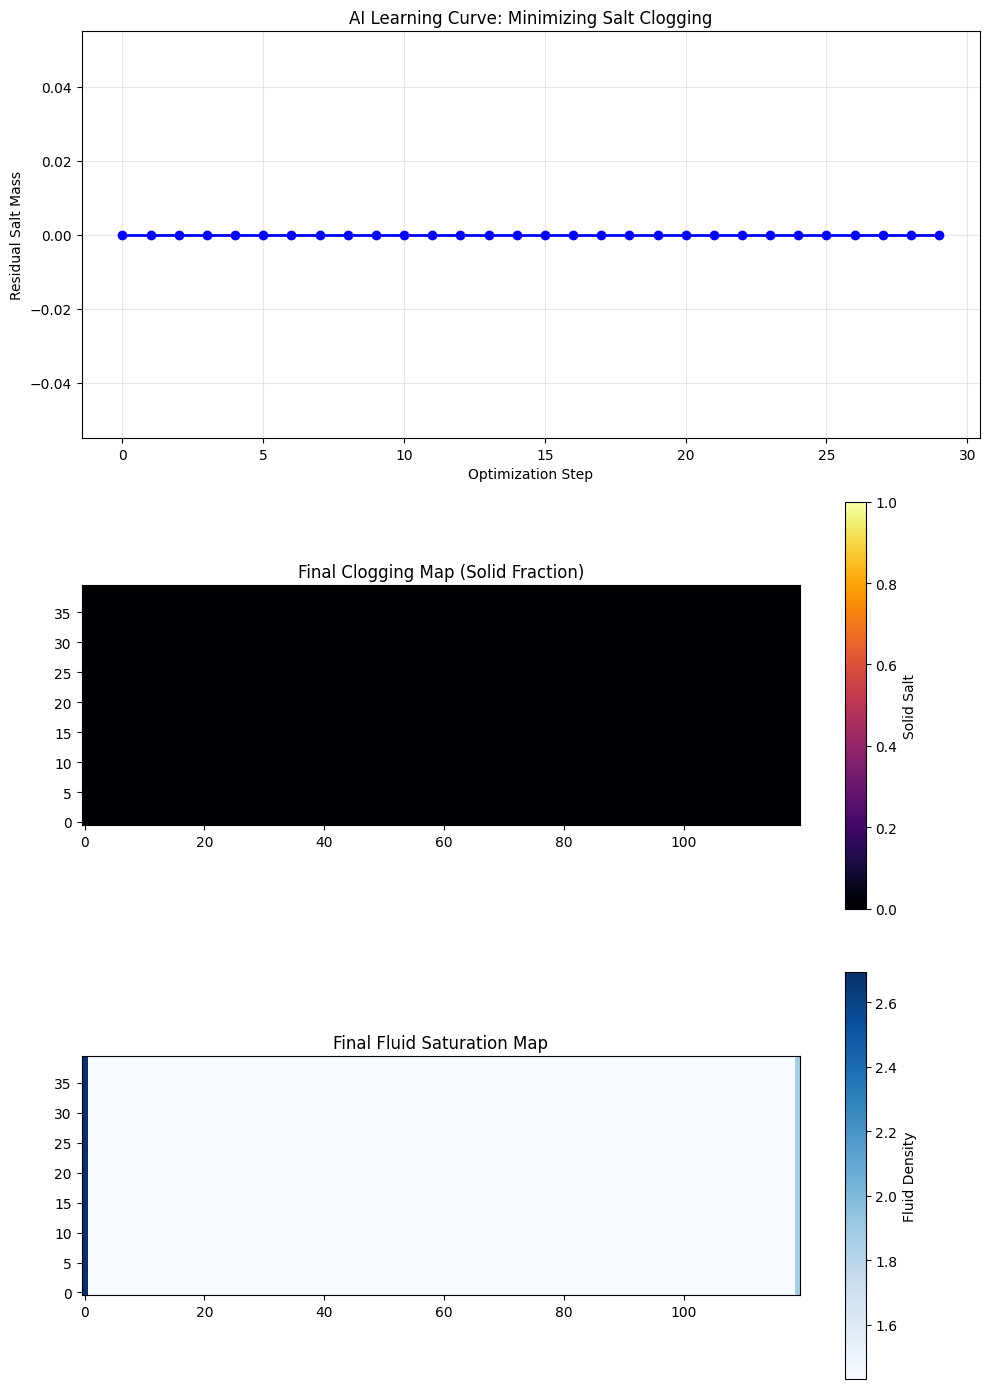

In [12]:
# --- STEP 4: RUN OPTIMIZATION LOOP ---

# 1. Setup Optimizer
# Initial Guess: Freq=0.03 (Slow), Amp=0.01 (Weak)
params = jnp.array([0.03, 0.01]) 

optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(params)

loss_history = []
param_history = []

print("Starting AI Optimization Loop (30 Iterations)...")
print("-" * 50)

for i in range(1, 31):
    # Calculate Loss and Gradients
    loss_val, grads = value_and_grad(simulation_loss)(params)
    
    # Update Parameters (Adam Optimizer)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    # Enforce Physical Limits
    # Frequency: 0.001 to 0.2 (Prevent crashing)
    # Amplitude: 0.001 to 0.15 (Prevent explosion)
    params = jnp.clip(params, jnp.array([0.001, 0.001]), jnp.array([0.2, 0.15]))
    
    loss_history.append(loss_val)
    param_history.append(params)
    
    # Live Reporting
    print(f"Iter {i:02d}: Loss = {loss_val:.5f} | Freq = {params[0]:.4f} | Amp = {params[1]:.4f}")

# --- STEP 5: VISUALIZE RESULTS ---
best_params = params
print("-" * 50)
print(f"OPTIMAL WAVEFORM FOUND: Freq={best_params[0]:.4f}, Amp={best_params[1]:.4f}")

# Re-run simulation with Best Params to get the maps
def render_map(opt_params):
    rho_init = jnp.ones((NX, NY))
    u_init = jnp.zeros((NX, NY, 2))
    state = (equilibrium(rho_init, u_init), equilibrium(jnp.zeros((NX, NY)), u_init), jnp.zeros((NX, NY)))
    
    t_arr = jnp.arange(MAX_STEPS)
    
    # Wrapper to freeze params
    def scanned_fn(state, t):
        return step_physics(state, (t, opt_params))
    
    final_state, _ = jax.lax.scan(scanned_fn, state, t_arr)
    return final_state

# Get Data
final_state_opt = render_map(best_params)
f_fin, _, phi_fin = final_state_opt
rho_fin = jnp.sum(f_fin, axis=-1)

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(10, 14))

# 1. Learning Curve
ax[0].plot(loss_history, 'b-o', linewidth=2)
ax[0].set_title("AI Learning Curve: Minimizing Salt Clogging")
ax[0].set_ylabel("Residual Salt Mass")
ax[0].set_xlabel("Optimization Step")
ax[0].grid(True, alpha=0.3)

# 2. Clogging Map (Where is the salt?)
im1 = ax[1].imshow(phi_fin.T, cmap='inferno', origin='lower', vmin=0, vmax=1)
ax[1].set_title("Final Clogging Map (Solid Fraction)")
plt.colorbar(im1, ax=ax[1], label="Solid Salt")

# 3. Flow Map (Where is the fluid?)
im2 = ax[2].imshow(rho_fin.T, cmap='Blues', origin='lower')
ax[2].set_title("Final Fluid Saturation Map")
plt.colorbar(im2, ax=ax[2], label="Fluid Density")

plt.tight_layout()
plt.show()

## 4. Visualization (2D Maps)
We re-run the simulation with the **Best Parameters** and plot the results.

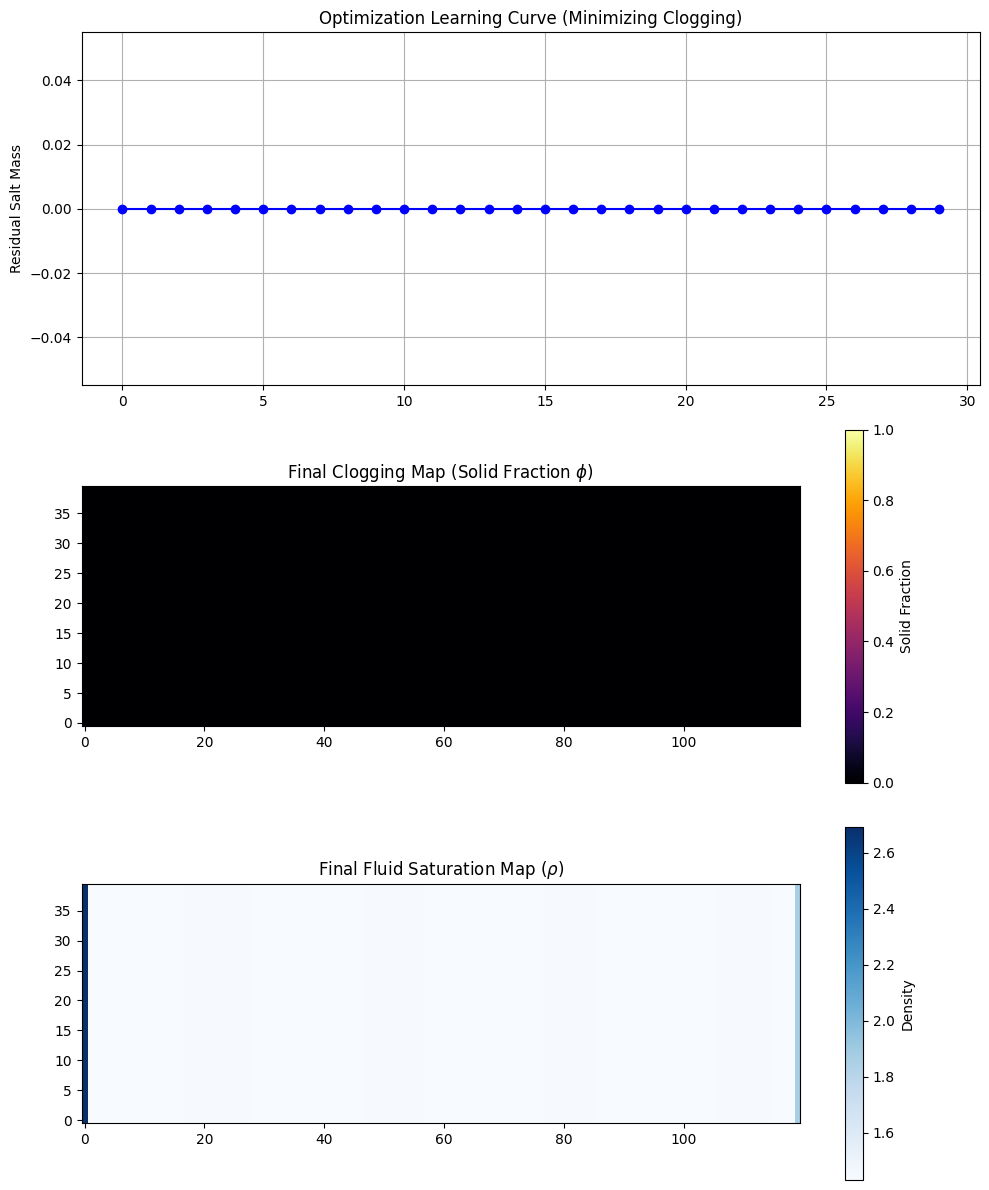

In [13]:
# Re-run to get map data
def render_map(opt_params):
    rho_init = jnp.ones((NX, NY))
    u_init = jnp.zeros((NX, NY, 2))
    state = (equilibrium(rho_init, u_init), equilibrium(jnp.zeros((NX, NY)), u_init), jnp.zeros((NX, NY)))
    
    t_arr = jnp.arange(MAX_STEPS)
    def scanned_fn(state, t):
        return step_physics(state, (t, opt_params))
    
    final_state, _ = jax.lax.scan(scanned_fn, state, t_arr)
    return final_state

final_state_opt = render_map(best_params)
f_fin, _, phi_fin = final_state_opt
rho_fin = jnp.sum(f_fin, axis=-1)

# --- PLOT ---
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# 1. Optimization Curve
ax[0].plot(loss_history, 'b-o')
ax[0].set_title("Optimization Learning Curve (Minimizing Clogging)")
ax[0].set_ylabel("Residual Salt Mass")
ax[0].grid(True)

# 2. Clogging Map 
im1 = ax[1].imshow(phi_fin.T, cmap='inferno', origin='lower', vmin=0, vmax=1)
ax[1].set_title(r"Final Clogging Map (Solid Fraction $\phi$)")
plt.colorbar(im1, ax=ax[1], label="Solid Fraction")

# 3. Saturation Map
im2 = ax[2].imshow(rho_fin.T, cmap='Blues', origin='lower')
ax[2].set_title(r"Final Fluid Saturation Map ($\rho$)")
plt.colorbar(im2, ax=ax[2], label="Density")

plt.tight_layout()
plt.show()

--- DIAGNOSTIC REPORT ---
1. Running Forward Pass...
   -> Current Loss (Total Salt Mass): 0.0001
   [PASS] Clogging is happening (Loss > 0).

2. Checking Gradients...
   -> Gradients: Freq_Grad=-2.599842, Amp_Grad=0.400822
   [PASS] Gradients exist. The optimizer should learn.

3. Visualizing Waveform...


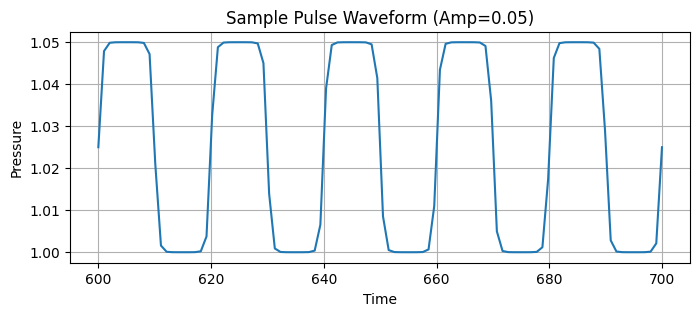

--- END REPORT ---


In [14]:
import jax.numpy as jnp
from jax import value_and_grad

print("--- DIAGNOSTIC REPORT ---")

# 1. CHECK CLOGGING (Is salt actually forming?)
# We run a short forward pass with default parameters
test_params = jnp.array([0.05, 0.05]) # Freq=0.05, Amp=0.05
print("1. Running Forward Pass...")
loss_val = simulation_loss(test_params)
print(f"   -> Current Loss (Total Salt Mass): {loss_val:.4f}")

if loss_val == 0:
    print("   [CRITICAL FAIL] Loss is 0. The simulation is not clogging. Optimizer has nothing to fix.")
    print("   FIX: Increase PRECIP_RATE or Salt Concentration in Step 4.")
else:
    print("   [PASS] Clogging is happening (Loss > 0).")

# 2. CHECK GRADIENTS (Is the optimizer blind?)
# We calculate gradients manually once
print("\n2. Checking Gradients...")
loss, grads = value_and_grad(simulation_loss)(test_params)
print(f"   -> Gradients: Freq_Grad={grads[0]:.6f}, Amp_Grad={grads[1]:.6f}")

if jnp.all(grads == 0):
    print("   [CRITICAL FAIL] Gradients are ZERO. The optimizer is 'blind'.")
    print("   CAUSE: The physics chain is broken. Likely 'jnp.where' or 'lax.select' is blocking the signal.")
    print("   FIX: We need to smooth out the 'if' logic in step_physics.")
elif jnp.any(jnp.isnan(grads)):
    print("   [CRITICAL FAIL] Gradients are NaN (Not a Number).")
    print("   CAUSE: Physics instability (Velocity exploded).")
    print("   FIX: Reduce 'P_HIGH' pressure or decrease 'TAU' slightly.")
else:
    print("   [PASS] Gradients exist. The optimizer should learn.")

# 3. VISUALIZE PULSE (Is the waveform making sense?)
print("\n3. Visualizing Waveform...")
t_test = jnp.linspace(600, 700, 100)
# Use vmap to check the pulse policy function logic
pressures = jax.vmap(pulse_policy, in_axes=(0, None))(t_test, test_params)
plt.figure(figsize=(8,3))
plt.plot(t_test, pressures)
plt.title(f"Sample Pulse Waveform (Amp={test_params[1]})")
plt.ylabel("Pressure")
plt.xlabel("Time")
plt.grid(True)
plt.show()

print("--- END REPORT ---")